<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/Training_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training a deep neural network isn’t a walk in the park. Here are some of the problems you could run into:

- You may be faced with the problem of gradients growing ever smaller or larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.

- You might not have enough training data for such a large network, or it might be too costly to label.

- Training may be extremely slow.

- A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

#The Vanishing/Exploding Gradients Problems

backpropagation algorithm’s second phase works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem,

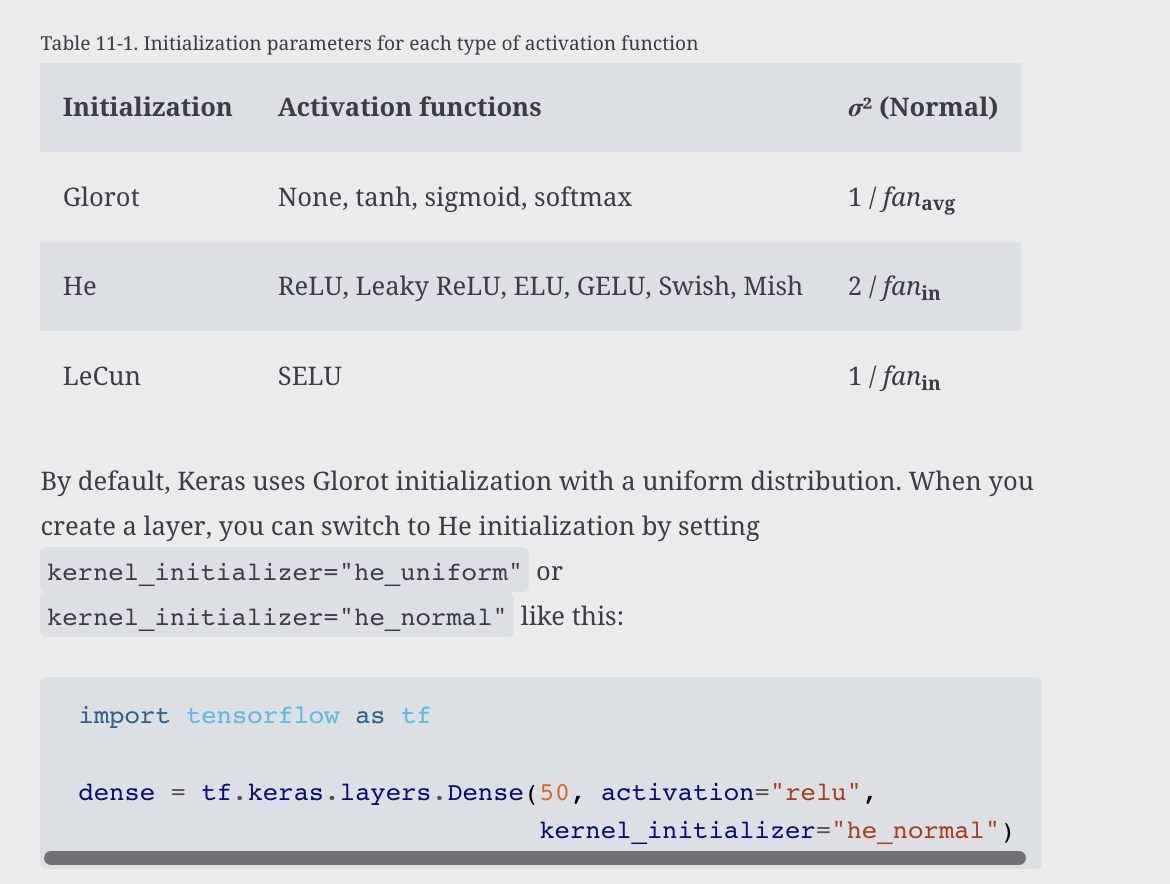

#Better Activation Functions
One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function.

ReLU activation function, mostly because it does not saturate for positive values, and also because it is very fast to compute.

In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the input of the ReLU function (i.e., the weighted sum of the neuron’s inputs plus its bias term) is negative for all instances in the training set. When this happens, it just keeps outputting zeros, and gradient descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.⁠4

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU.

Keras includes the classes LeakyReLU and PReLU in the tf.keras.layers package. Just like for other ReLU variants, you should use He initialization with these.

In [2]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [3]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

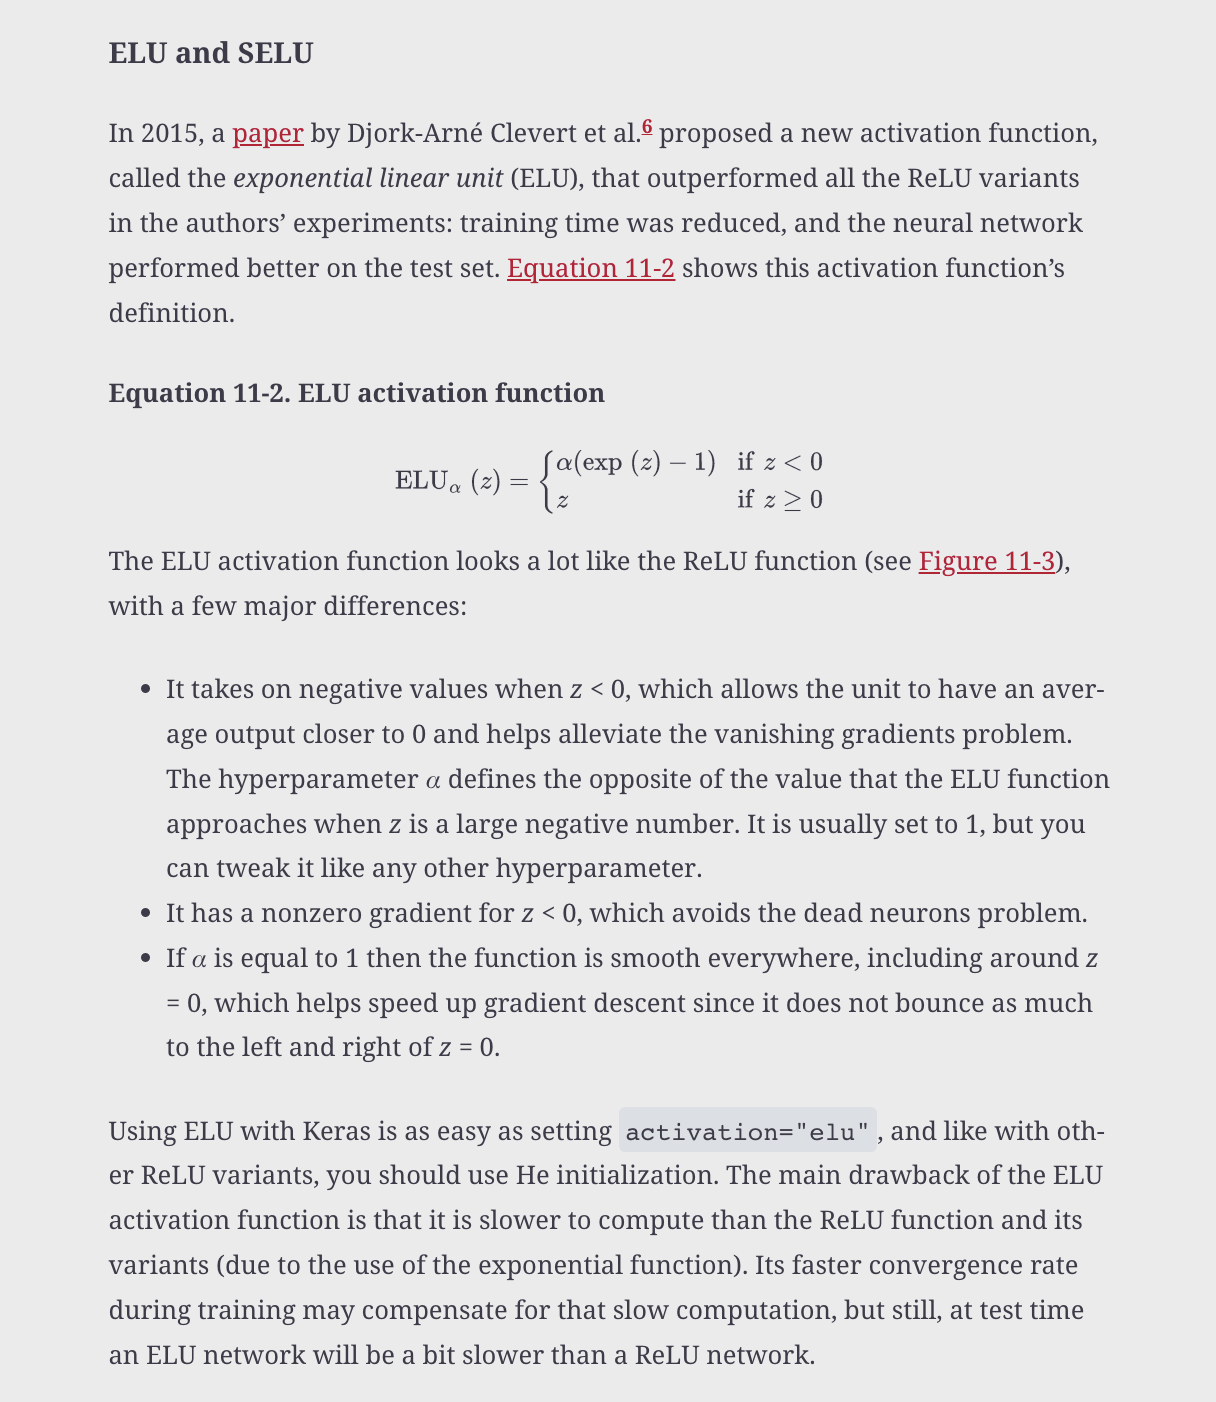

In [1]:
import sys

assert sys.version_info >= (3, 7)

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


#Batch Normalization

Sergey Ioffe and Christian Szegedy proposed a technique called batch normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. 

Ioffe and Szegedy demonstrated that batch normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the sigmoid activation function. 

In [4]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [5]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [7]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 0.5518 - accuracy: 0.8086 - val_loss: 0.4039 - val_accuracy: 0.8550
Epoch 2/2
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4062 - accuracy: 0.8569 - val_loss: 0.3673 - val_accuracy: 0.8650


since a batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer by passing use_bias=False when creating it. Lastly, you can usually drop the first BN layer to avoid sandwiching the first hidden layer between two BN layers. 

# Gradient Clipping
Another technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called gradient clipping

In [9]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [10]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

#Reusing Pretrained Layers

if you find such as neural network, then you can generally reuse most of its layers, except for the top ones. This technique is called transfer learning. It will not only speed up training considerably, but also requires significantly less training data.

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects, and you now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network

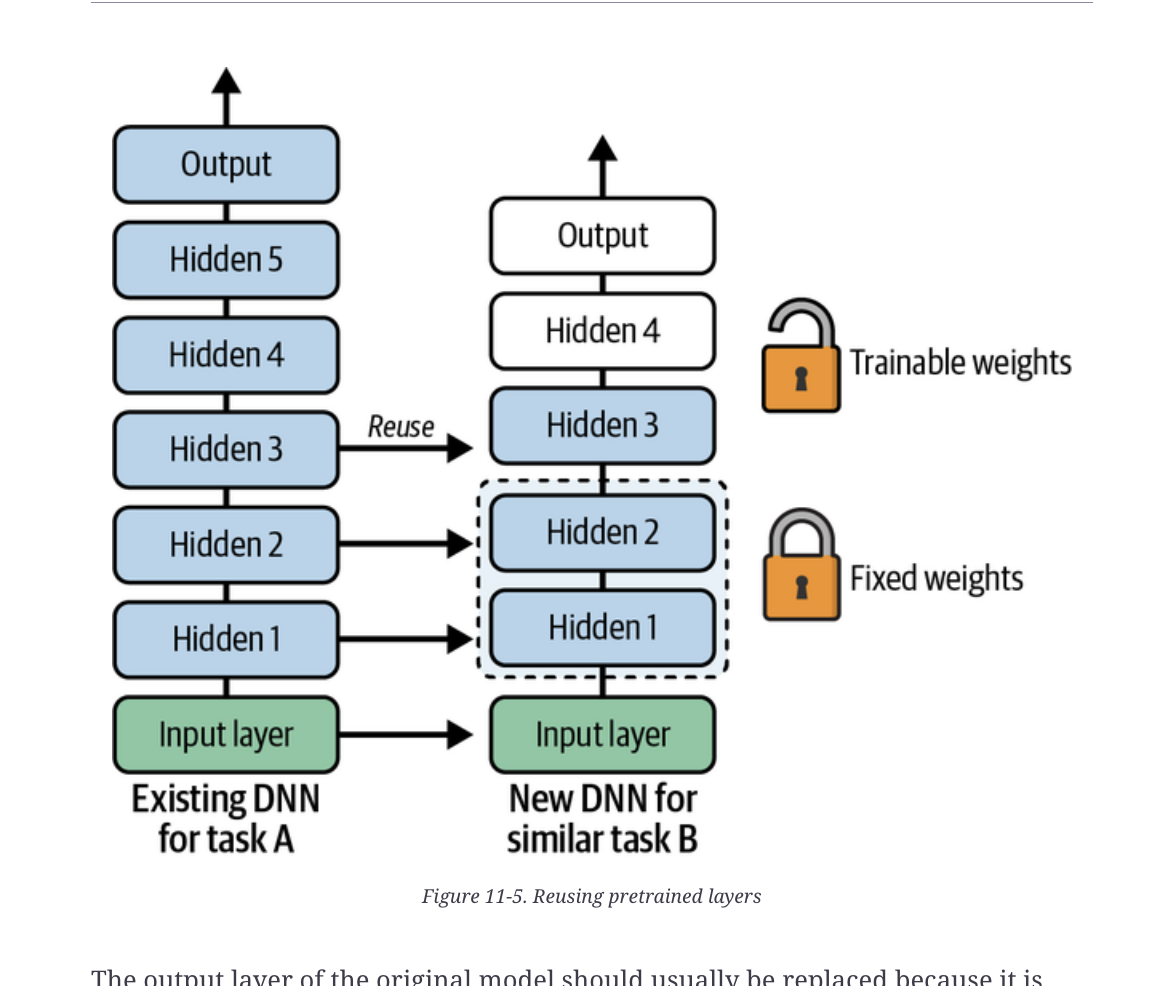

Try freezing all the reused layers first (i.e., make their weights non-trainable so that gradient descent won’t modify them and they will remain fixed), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.



#Transfer Learning with Keras

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.1973 - accuracy: 0.6307 - val_loss: 0.7175 - val_accuracy: 0.7681
Epoch 2/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.6183 - accuracy: 0.7943 - val_loss: 0.5290 - val_accuracy: 0.8200
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4961 - accuracy: 0.8388 - val_loss: 0.4525 - val_accuracy: 0.8448
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4331 - accuracy: 0.8594 - val_loss: 0.4043 - val_accuracy: 0.8681
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3929 - accuracy: 0.8724 - val_loss: 0.3742 - val_accuracy: 0.8744
Epoch 6/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3648 - accuracy: 0.8798 - val_loss: 0.3525 - val_accuracy: 0.8829
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3447 - accuracy: 0.8845 - val_loss: 0.3365 - val_accuracy:

In [12]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 43ms/step - loss: 0.7794 - accuracy: 0.4450 - val_loss: 0.7393 - val_accuracy: 0.4847
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7348 - accuracy: 0.4400 - val_loss: 0.7062 - val_accuracy: 0.4946
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.7002 - accuracy: 0.4650 - val_loss: 0.6778 - val_accuracy: 0.5341
Epoch 4/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6690 - accuracy: 0.5850 - val_loss: 0.6578 - val_accuracy: 0.6142
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6483 - accuracy: 0.6750 - val_loss: 0.6389 - val_accuracy: 0.7230
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6282 - accuracy: 0.7850 - val_loss: 0.6220 - val_accuracy: 0.7794
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6098 - accuracy: 0.8250 - val_loss: 0.6055 - val_accuracy: 0.8061
Epoch 8/20
7/7 [===========

[0.4737357497215271, 0.909500002861023]

#Unsupervised Pretraining

##Faster Optimizers

In [13]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [14]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7273 - accuracy: 0.7490 - val_loss: 0.5110 - val_accuracy: 0.8146
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4766 - accuracy: 0.8331 - val_loss: 0.4448 - val_accuracy: 0.8400
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4296 - accuracy: 0.8471 - val_loss: 0.4136 - val_accuracy: 0.8510
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4002 - accuracy: 0.8591 - val_loss: 0.3884 - val_accuracy: 0.8582
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3787 - accuracy: 0.8655 - val_loss: 0.3738 - val_accuracy: 0.8650
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3666 - accuracy: 0.8693 - val_loss: 0.3723 - val_accuracy: 0.8646
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3497 - accuracy: 0.8732 - val_loss: 0.3691 - val_accuracy:

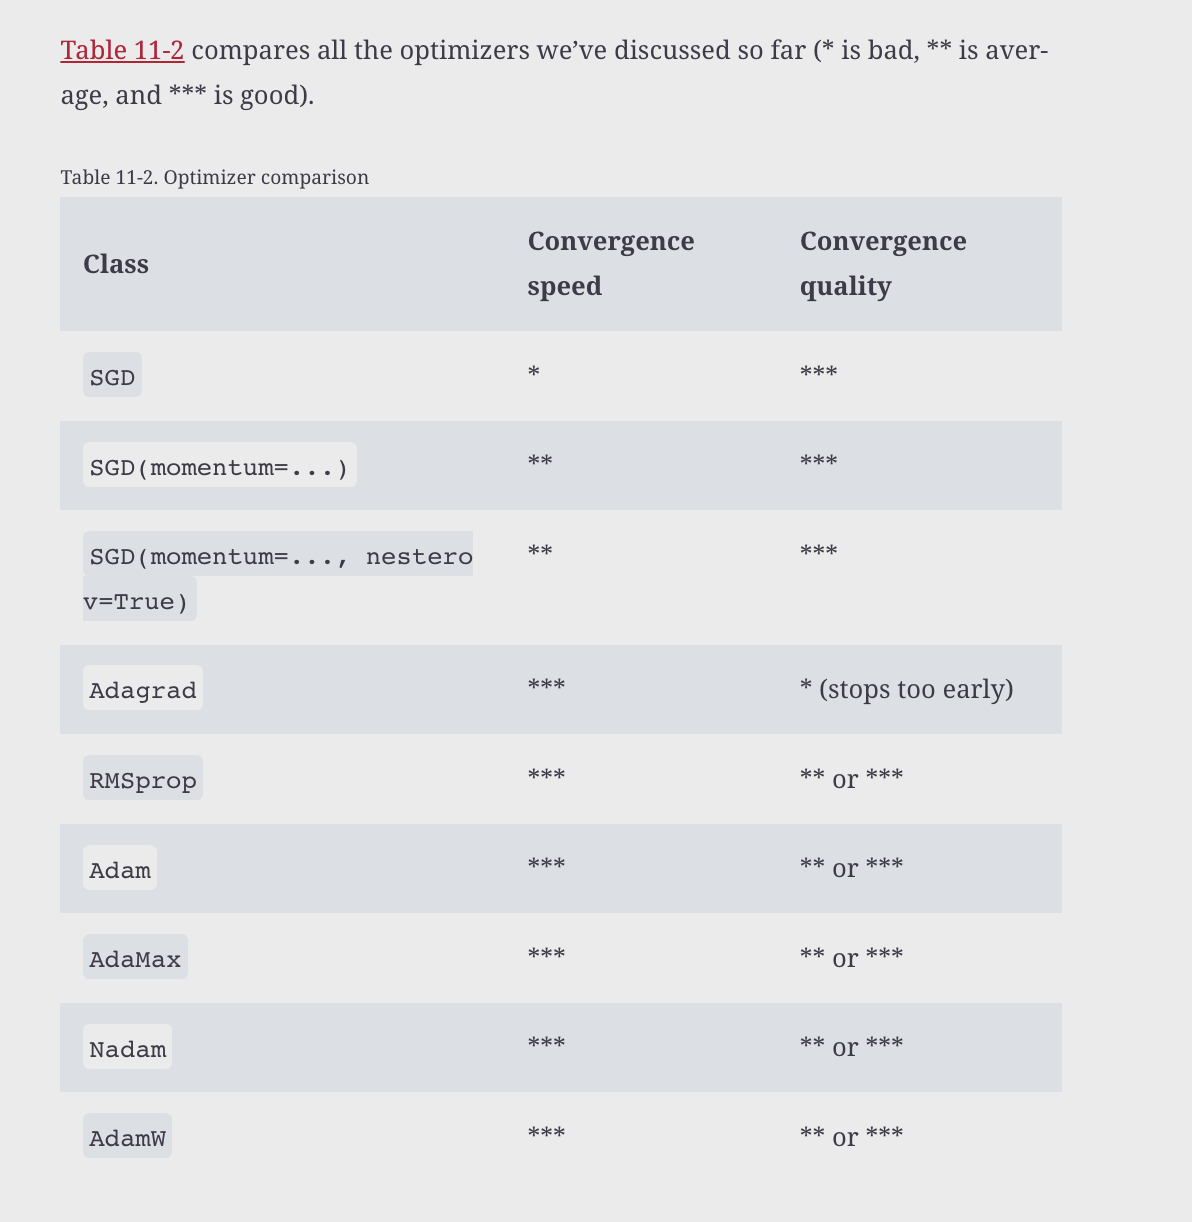

#Learning Rate Scheduling

Finding a good learning rate is very important. If you set it much too high, training may diverge (as discussed in “Gradient Descent”). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum and never really settling down. 

- Power scheduling

Set the learning rate to a function of the iteration number t: η(t) = η0 / (1 + t/s)c. The initial learning rate η0, the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, the learning rate is down to η0 / 2. After s more steps it is down to η0 / 3, then it goes down to η0 / 4, then η0 / 5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning η0 and s (and possibly c).

- Exponential scheduling

Set the learning rate to η(t) = η0 0.1t/s. The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

- Piecewise constant scheduling

Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

- Performance scheduling

Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

- 1cycle scheduling

1cycle was introduced in a 2018 paper by Leslie Smith.⁠24 Contrary to the other approaches, it starts by increasing the initial learning rate η0, growing linearly up to η1 halfway through training. Then it decreases the learning rate linearly down to η0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate η1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η0 is usually 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, compared to 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture). This feat was dubbed super-convergence.

# Avoiding Overfitting Through Regularization